In [2]:
# Imports
import os, subprocess, json
from datetime import datetime

# Environmental Variables
from dotenv import load_dotenv

import pandas as pd

# HTTP Client
import requests
# For parsing and sifting through HTML
from bs4 import BeautifulSoup

In [182]:
# Set max rows for Pandas
pd.set_option('display.max_rows', 50)

## CRISP-DM
![CRISP-DM](../reports/figures/CRISP_DM.png)

## Data Preparation

### John Hopkins GITHUB time series data (csv)

In [3]:
# Read data into dataframe
data_path= "../data/raw/JH_dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

pd_raw= pd.read_csv(data_path)


In [184]:
pd_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,5889,6016,6151,6275,6411,6536,6676,6817,6971,7117
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,939,944,955,955,955,963,963,977,981,989
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1395,1483,1538,1572,1672,1679,1735,1762,1815,1852


### Data subset with ISO date as index

In [5]:
# MOVE DATES FROM HEADERS TO ROWS
# Get date columns (col 4 and beyond)
date_raw= pd_raw.columns[4:]

# CONVERT DATES TO ISO COMPLIANT FORMAT
# Convert strings to datetime object
date_dt= [datetime.strptime(each, "%m/%d/%y") for each in date_raw]
# Convert datetime object to ISO date string
date_iso= [each.strftime("%Y-%m-%d") for each in date_dt]

# Create DataFrame
date_fr= pd.DataFrame({
    "date": date_iso
})

date_fr.head()

,date
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26


In [6]:
# Get the countries in the dataset
ctys= pd_raw.loc[:, "Country/Region"]
# Get unique countries
ctys= ctys.unique()

In [7]:
pd_raw[pd_raw["Country/Region"] == "Germany"].iloc[:, 4:].to_numpy().sum(axis=0).shape

(220,)

In [8]:
# Small subset of countrie for trial
small_ctys= ["Spain", "Nigeria", "Germany", "Afghanistan", "Italy"]

# Push columns into the dataframe created previosly with the dates as a column
for cty in small_ctys:
    # Append new column to dataframe (Not expensive!)
    date_fr[cty]= pd_raw[pd_raw["Country/Region"] == cty].iloc[:, 4:].to_numpy().sum(axis=0)


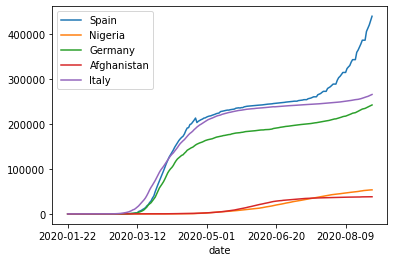

In [9]:
# Set date as index
date_fr= date_fr.set_index("date")
# Plot with dates as indices
date_fr.plot()

In [10]:
# Save data subset
date_fr.to_csv(
    "../data/processed/COVID_flat_small.csv", sep=";"
)

### Relational data model

Here we select the primary key as the date, state, and country columns as 
each is required to uniquely identify every data row(entry)

In [191]:
# Read data into dataframe
data_path= "../data/raw/JH_dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

pd_raw= pd.read_csv(data_path)

pd_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,5889,6016,6151,6275,6411,6536,6676,6817,6971,7117
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,939,944,955,955,955,963,963,977,981,989
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1395,1483,1538,1572,1672,1679,1735,1762,1815,1852


In [192]:
pd_raw[pd_raw["Province/State"]== "Zhejiang"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20
88,Zhejiang,China,29.1832,120.0934,10,27,43,62,104,128,...,1270,1270,1271,1272,1273,1274,1275,1275,1275,1275


In [193]:
# Create DataFrame
pd_base= pd.DataFrame(pd_raw)

# Discard Lat and Long columns
pd_base= pd_base.drop(["Lat", "Long"], axis=1)

pd_base= pd_base.fillna('no')

# Rename columns for convienence
pd_base= pd_base.rename(columns={"Province/State": "state", "Country/Region": "country"})

In [194]:
pd_base[pd_base["state"]== "Zhejiang"]

,state,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20
88,Zhejiang,China,10,27,43,62,104,128,173,296,...,1270,1270,1271,1272,1273,1274,1275,1275,1275,1275


In [195]:
# Index data by (state, country)
pd_base= pd_base.set_index(["state", "country"]).T
pd_base.tail()

state            no                                                     \
country Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
8/10/20       37162    6536   35712     963   1679                  92   
8/11/20       37269    6676   36204     963   1735                  92   
8/12/20       37345    6817   36699     977   1762                  92   
8/13/20       37424    6971   37187     981   1815                  92   
8/14/20       37431    7117   37664     989   1852                  93   

state                     Australian Capital Territory New South Wales  ...  \
country Argentina Armenia                    Australia       Australia  ...   
8/10/20    253868   40433                          113            3897  ...   
8/11/20    260911   40593                          113            3915  ...   
8/12/20    268574   40794                          113            3927  ...   
8/13/20    276072   41023                          113            3936  ...   
8/14/20    282437   41299                          113            3945  ...   

state               no                                       \
country United Kingdom Uruguay Uzbekistan Venezuela Vietnam   
8/10/20         311641    1364      31304     26800     847   
8/11/20         312789    1385      31747     27938     866   
8/12/20         313798    1393      32654     29088     883   
8/13/20         314927    1409      33323     30369     911   
8/14/20         316367    1421      33821     31381     930   

state                                                            
country West Bank and Gaza Western Sahara Yemen Zambia Zimbabwe  
8/10/20              14510             10  1832   8210     4748  
8/11/20              14875             10  1831   8275     4818  
8/12/20              15184             10  1841   8501     4893  
8/13/20              15491             10  1847   8663     4990  
8/14/20              15834             10  1858   9021     5072  

[5 rows x 266 columns]

In [196]:
# Stack the data by dates
rel_fr= pd_base.stack(["state", "country"]).reset_index()
rel_fr.tail()

,level_0,state,country,0
54791,8/14/20,no,West Bank and Gaza,15834.0
54792,8/14/20,no,Western Sahara,10.0
54793,8/14/20,no,Yemen,1858.0
54794,8/14/20,no,Zambia,9021.0
54795,8/14/20,no,Zimbabwe,5072.0


In [197]:
rel_fr[rel_fr['country']== 'Nigeria']

,level_0,state,country,0
204,1/22/20,no,Nigeria,0.0
470,1/23/20,no,Nigeria,0.0
736,1/24/20,no,Nigeria,0.0
1002,1/25/20,no,Nigeria,0.0
1268,1/26/20,no,Nigeria,0.0
...,...,...,...,...
53670,8/10/20,no,Nigeria,46867.0
53936,8/11/20,no,Nigeria,47290.0
54202,8/12/20,no,Nigeria,47743.0
54468,8/13/20,no,Nigeria,48116.0


In [198]:
# Set new column names
rel_fr= rel_fr.rename(columns={"level_0": "date", 0:"confirmed"})

rel_fr.tail()

,date,state,country,confirmed
54791,8/14/20,no,West Bank and Gaza,15834.0
54792,8/14/20,no,Western Sahara,10.0
54793,8/14/20,no,Yemen,1858.0
54794,8/14/20,no,Zambia,9021.0
54795,8/14/20,no,Zimbabwe,5072.0


In [199]:
# View datatypes
rel_fr.dtypes

date          object
state         object
country       object
confirmed    float64
dtype: object

In [200]:
# Convert date to datetime type
rel_fr["date"]= rel_fr.date.astype("datetime64[ns]")

rel_fr.date.head()

0   2020-01-22
1   2020-01-22
2   2020-01-22
3   2020-01-22
4   2020-01-22
Name: date, dtype: datetime64[ns]

In [202]:
# Save relational data model
rel_fr.to_csv(
    "../data/processed/COVID_relational_full.csv", sep=";", index=False
)